In [1]:
import os
import numpy as np
import cv2
import torch
import torch.optim as optim

import terratorch
from terratorch.datamodules import Landslide4SenseNonGeoDataModule
from terratorch.datasets import Landslide4SenseNonGeo
from terratorch.tasks import SemanticSegmentationTask

import albumentations
from albumentations import Compose, Flip
from albumentations.pytorch import ToTensorV2

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.21 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
/dccstor/geofm-finetuning/pedrohc/miniforge3/envs/benchmark/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


wxc_downscaling not installed
wxc_downscaling not installed


In [ ]:
# If you dont have the dataset yet, download it with
from huggingface_hub import snapshot_download

repo_id = "ibm-nasa-geospatial/Landslide4sense"
local_path = snapshot_download(repo_id=repo_id)

# Landslide4Sense Example

In [2]:
DATASET_PATH = os.path.join('root_dir', 'Landslide4sense')

In [3]:
# those are the recommended transforms for this task
transforms = [
    albumentations.HorizontalFlip(),
    albumentations.Resize(224, 224),
    albumentations.pytorch.transforms.ToTensorV2(),
]

In [4]:
# this datamodule allows access to the dataset in its various splits.
datamodule = Landslide4SenseNonGeoDataModule(
    batch_size=16,
    data_root=DATASET_PATH,
    train_transform=transforms,
    val_transform=transforms,
    test_transform=transforms,
)

In [5]:
# checking for the dataset means and stds
datamodule.means, datamodule.stds

([-0.4914,
  -0.3074,
  -0.1277,
  -0.0625,
  0.0439,
  0.0803,
  0.0644,
  0.0802,
  0.3,
  0.4082,
  0.0823,
  0.0516,
  0.3338,
  0.7819],
 [0.9325,
  0.8775,
  0.886,
  0.8869,
  0.8857,
  0.8418,
  0.8354,
  0.8491,
  0.9061,
  1.6072,
  0.8848,
  0.9232,
  0.9018,
  1.2913])

In [6]:
# checking datasets train split size
datamodule.setup("fit")
train_dataset = datamodule.train_dataset
len(train_dataset)

3799

In [7]:
# checking datasets available bands
train_dataset.all_band_names

('COASTAL AEROSOL',
 'BLUE',
 'GREEN',
 'RED',
 'RED_EDGE_1',
 'RED_EDGE_2',
 'RED_EDGE_3',
 'NIR_BROAD',
 'WATER_VAPOR',
 'CIRRUS',
 'SWIR_1',
 'SWIR_2',
 'SLOPE',
 'DEM')

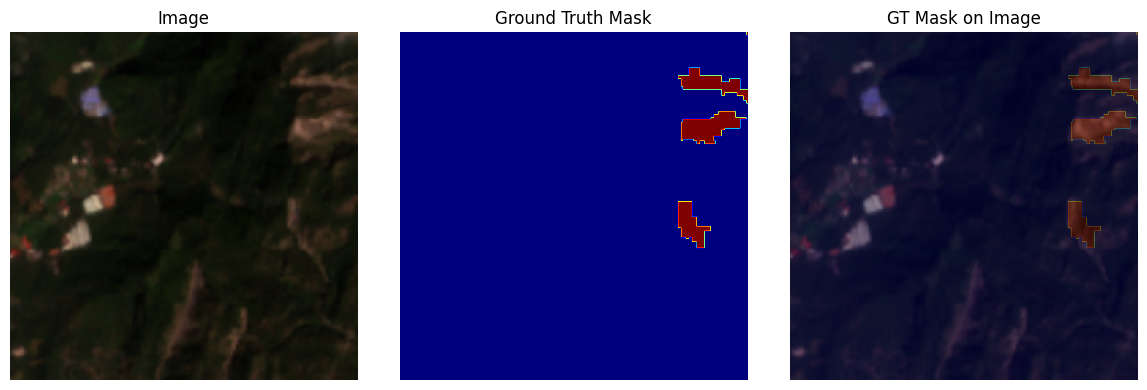

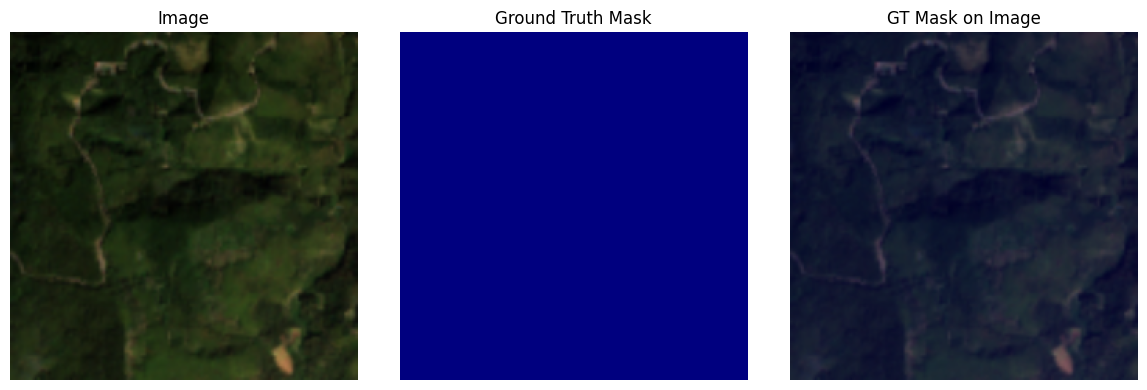

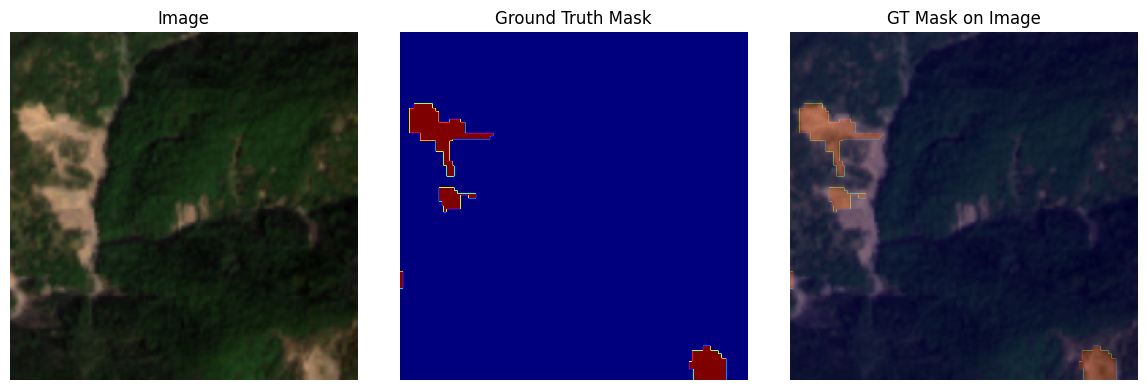

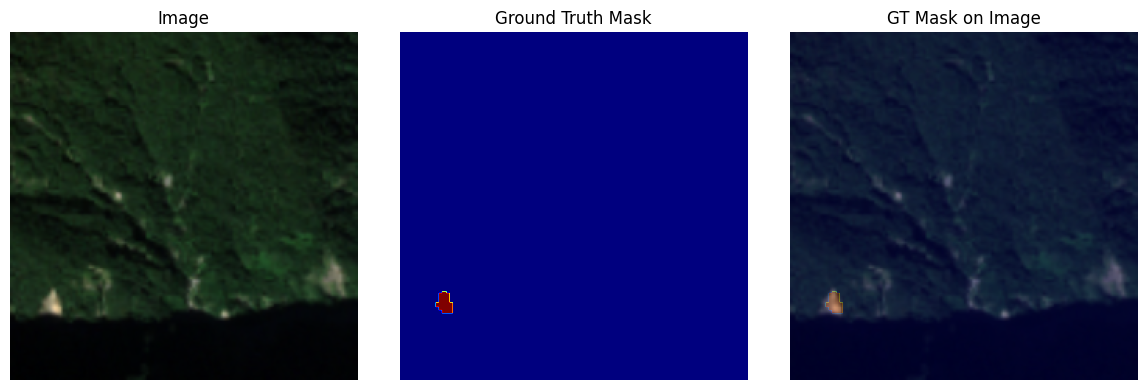

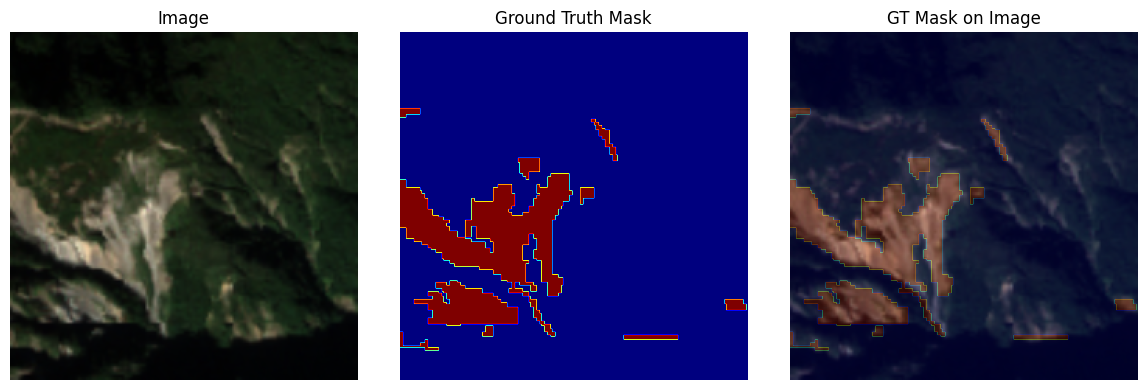

In [8]:
# ploting a few samples
for i in range(5):
    train_dataset.plot(train_dataset[i])

In [9]:
# checking datasets validation split size
val_dataset = datamodule.val_dataset
len(val_dataset)

245

In [10]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

800

In [ ]:
# Logger
logger = TensorBoardLogger(
    save_dir="output",
    name="tutorial"
)

# Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices="auto",
    num_nodes=1,
    logger = logger,
    precision="16-mixed",
    max_epochs=1,
    check_val_every_n_epoch=1,
    log_every_n_steps=1,
    enable_checkpointing=False,
    default_root_dir="root_dir",
)

# DataModule
data_module = Landslide4SenseNonGeoDataModule(
    batch_size=8,
    bands = ["BLUE", "GREEN", "RED", "NIR_BROAD", "SWIR_1", "SWIR_2"],
    data_root=DATASET_PATH,
    train_transform=transforms,
    val_transform=transforms,
    test_transform=transforms,
)

# Model
model = SemanticSegmentationTask(
    model_args={
        "decoder": "UperNetDecoder",
        "backbone_pretrained": False,
        "backbone": "prithvi_eo_v2_300", # Model can be either prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
        "backbone_in_channels": 6,
        "rescale": True,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_BROAD", "SWIR_1", "SWIR_2"],
        "backbone_num_frames": 1,
        "num_classes": 2,
        "head_dropout": 0.1,
        "decoder_channels": 256,
        "decoder_scale_modules": True,
        "head_channel_list": [128, 64],
        "necks": [
            {
                "name": "SelectIndices",
                #"indices": [2, 5, 8, 11] # indices for prithvi_vit_100
                "indices": [5, 11, 17, 23] # indices for prithvi_vit_300
                #"indices": [7, 15, 23, 31] # indices for prithvi_vit_600
            },
            {
                "name": "ReshapeTokensToImage"
            }
        ]
    },
    plot_on_val=False,
    loss="focal",
    ignore_index=-1,
    freeze_backbone=False,
    freeze_decoder=False,
    model_factory="EncoderDecoderFactory",
)

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=5.5e-5,
    weight_decay=0.05
)


# Training
trainer.fit(model, datamodule=data_module)
